In [65]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy import modeling
from scipy.optimize import curve_fit
from astropy import wcs
from ROHSApy import ROHSA
from scipy.ndimage import gaussian_filter
import numpy.ma as ma

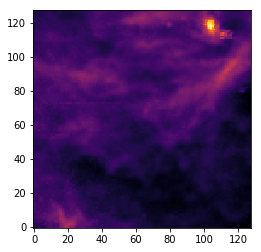

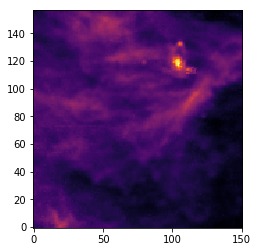

(621, 157, 151)


In [80]:
fitsname = "GHIGLS_UMA_Tb.fits"
hdu = fits.open(fitsname)
hdr = hdu[0].header
#hdr['CRPIX3'] -= 370
cube = hdu[0].data[0][:, :, :]
rms = hdu[2].data[50:82, 80:112]
mask = hdu[1].data
#LVC IS LOCATED AT 
#cube = hdu[0].data[0][300:350, :, :]
#IVC IS LOCATED AT 
#cube = hdu[0].data[0][360:420, :, :]

#The data from the cube was plotted
plt.figure()
plt.imshow(np.sum(cube[:, :128, 0:128],0), origin="lower", cmap="inferno")
plt.show()
plt.imshow(np.sum(cube[:, :, :],0), origin="lower", cmap="inferno")
plt.show()


def wcs2D(hdr):
    w = wcs.WCS(naxis=2)
    w.wcs.crpix = [hdr['CRPIX1'], hdr['CRPIX2']]
    w.wcs.cdelt = np.array([hdr['CDELT1'], hdr['CDELT2']])
    w.wcs.crval = [hdr['CRVAL1'], hdr['CRVAL2']]
    w.wcs.ctype = [hdr['CTYPE1'], hdr['CTYPE2']]
    return w
w = wcs2D(hdr)

print(cube.shape)

In [67]:
#here I will try and use the scipy function gaussian_filter to take a 32:32 region of gaussian filtered data
galaxy = cube[:, 110:142, 90:122]

#first i picked a region in the middle of the cube where the data seemed to be relatively normal
filter_region = hdu[0].data[0][300:420, 50:82, 80:112]
rms = hdu[2].data[50:82, 80:112]

#next i caucluated the nosie from before
noise = rms[15,15]*(1+(cube[:,15,15]/20))

#next i used the gaussian filter to smooth over the area that we picked
filtered_region = gaussian_filter(filter_region, sigma=np.std(noise))

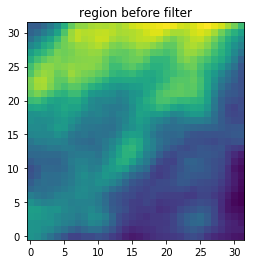

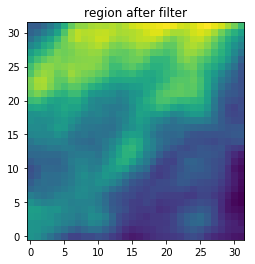

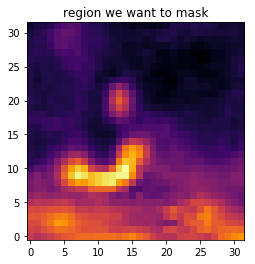

In [68]:
plt.imshow(np.sum(filter_region, axis = 0), origin = 'lower')
plt.title('region before filter')
plt.show()

plt.imshow(np.sum(filtered_region, axis = 0), origin = 'lower')
plt.title('region after filter')
plt.show()

plt.imshow(np.sum(galaxy, axis = 0), origin = 'lower', cmap = 'inferno')
plt.title('region we want to mask')
plt.show()

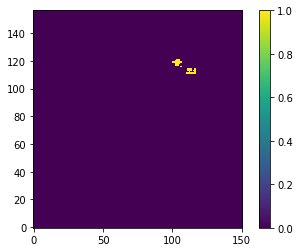

In [69]:
plt.imshow(mask, origin = 'lower')
plt.colorbar()

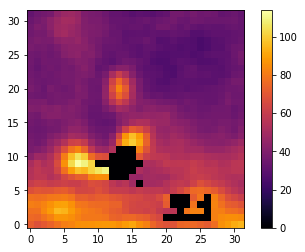

In [70]:

# Defect image over the same region in each color channel
#image_defect = image_orig.copy()
#for layer in range(image_defect.shape[-1]):
    #image_defect[np.where(mask)] = 0

#image_result = inpaint.inpaint_biharmonic(image_defect, mask,
#multichannel=True)

#here I just directly subtracted out the masked region for the galaxies
new_mask = np.where(mask == 0, 1,0)

masked_cube = np.copy(cube)
for i in range(cube.shape[0]):
    masked_cube[i] = masked_cube[i]*new_mask

plt.imshow(np.sum(masked_cube[:, 110:142, 90:122], 0), origin = 'lower', cmap = 'inferno')
plt.colorbar()

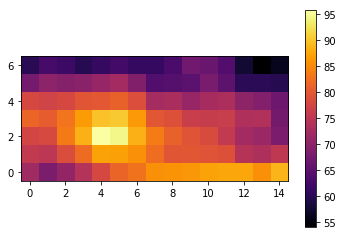

In [71]:
#next I want to find a small region near the galaxies to use as a replacement for the region we masked

#first i will try and find a region nearby that doesn't include the mask

plt.imshow(np.sum(masked_cube[:,110:117, 90:105], 0) , origin = 'lower', cmap = 'inferno')
plt.colorbar()


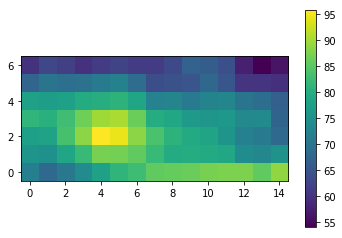

In [72]:
#i will use this region right between the two galaxies to fill the NANs with, first, i will smooth it
filler_region = masked_cube[:,110:117, 90:105]
#next i used the gaussian filter to smooth over the area that we picked
#for the sigma of the gaussian filter, I used the sigma of the noise

filtered_region = gaussian_filter(filler_region, sigma=np.std(noise))

plt.imshow(np.sum(filtered_region, 0), origin = 'lower')
plt.colorbar()


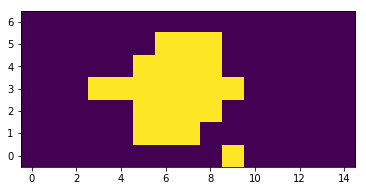

(7, 15) (50, 7, 15)


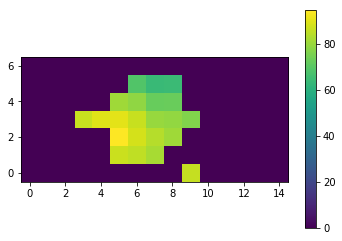

In [73]:
#now I can try and replace the nans using this filtered region and our original mask
#since the mask is 0 everywhere other than our desired pixels, i can simply multiply the filtered region to the mask
#and then add them both together to get a final mask
submask1 = mask[116:123, 97:112]
plt.imshow(submask1, origin = 'lower')
plt.show()

print(np.shape(submask1), np.shape(filtered_region))

mask1 = submask1*filtered_region

#now we can plot the newly filled in region for the first part of the mask
plt.imshow(np.sum(mask1, 0), origin = 'lower')
plt.colorbar()

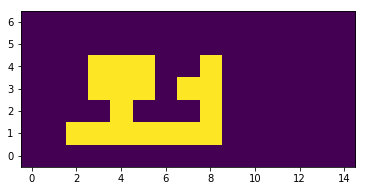

(7, 15) (50, 7, 15)


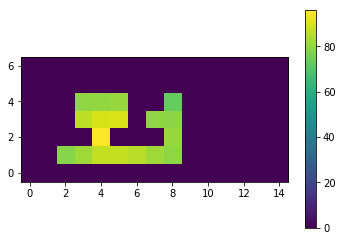

In [74]:
#next we repeat the process for the second part of the mask by filling it with the same subregion

submask2 = mask[110:117, 108:123]
plt.imshow(submask2, origin = 'lower')
plt.show()

print(np.shape(submask1), np.shape(filtered_region))

mask2 = submask2*filtered_region

#now we can plot the newly filled in region for the second part of the mask
plt.imshow(np.sum(mask2, 0), origin = 'lower')
plt.colorbar()


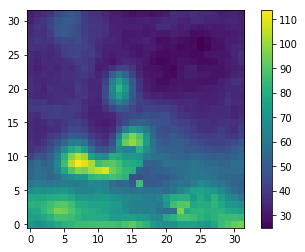

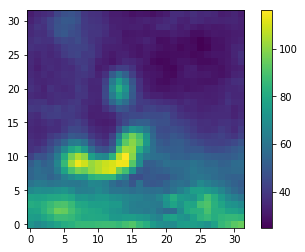

In [75]:
#now that we have successfully filled the regions with the desired region,
#we can directly replace the regions in the cube with the filled masked regions

masked_cube[:,116:123, 97:112] = masked_cube[:,116:123, 97:112] + mask1
masked_cube[:,110:117, 108:123] = masked_cube[:,110:117, 108:123] + mask2

#now we can plot the newly filled in region for the first part of the mask
plt.imshow(np.sum(masked_cube[:,110:142, 90:122], 0), origin = 'lower')
plt.colorbar()
plt.show()
plt.imshow(np.sum(cube[:, 110:142, 90:122], 0), origin = 'lower')
plt.colorbar()
plt.show()

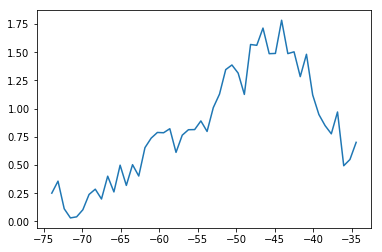

In [76]:
core = ROHSA(cube, hdr=hdr) 
cut_cube = cube[:, 110:142, 90:122]
cut_maskcube = masked_cube[:,110:142, 90:122]

plt.plot(core.v, cut_maskcube[:,15, 23])